Description: The goal of this code is to demonstrate how to train an LSTM model for temperature forecasting and evaluate its accuracy using historical data.


# 1.&nbsp;Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set_theme()
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

# 2.&nbsp;Data Preprocessing

In [12]:
# Load Data
florida = pd.read_csv('florid_file.csv') ; display("florida:", florida.shape, florida.head()) ; print()

florida["Date"] = pd.to_datetime(florida["Date"])

florida = florida[["Date", "Avg_Temp"]]
florida = florida.fillna(florida.bfill())
florida.columns = ['Date', 'Avg_Temp']

train = florida[:-225] ; len(train)
test  = florida[-225:] ; len(test)
train_dates = pd.to_datetime(train['Date'])
test_dates  = pd.to_datetime(test['Date'])

# Preparing Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Avg_Temp'].values.reshape(-1,1))

prediction_days = 225

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x , 0])
    y_train.append(scaled_data[x , 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

'florida:'

(3239, 8)

,Date,Avg_Temp,confidence_interval_temp,State,Country,Year,Month,Day
0,11/1/1743,17.694,2.514,Florida,United States,1743,11,1
1,12/1/1743,22.978,2.470,Florida,United States,1743,12,1
2,1/1/1744,22.978,2.470,Florida,United States,1744,1,1
3,2/1/1744,22.978,2.470,Florida,United States,1744,2,1
4,3/1/1744,22.978,2.470,Florida,United States,1744,3,1


# 3.&nbsp;LSTM Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 225, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 225, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 225, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 225, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

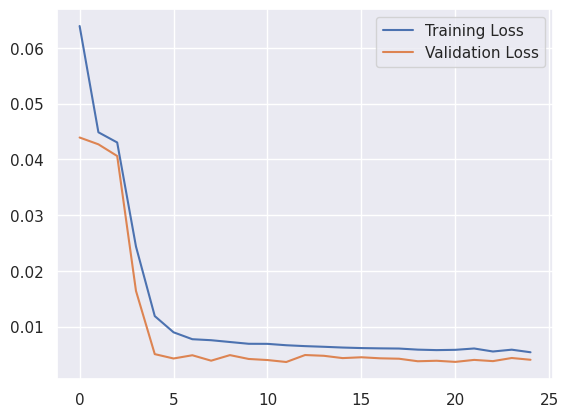

In [13]:
# Build The Model
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train, epochs = 25, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss']    , label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

# 4.&nbsp;Model Accuracy

In [14]:
# Take Test data Again
test.head()
actual_temp = test['Avg_Temp'].values
total_temp = pd.concat((train['Avg_Temp'], test['Avg_Temp']), axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test['Avg_Temp'], pred)

8/8 [==============================] - 3s 262ms/step


1.11307318745931

# 5.&nbsp;Visualization

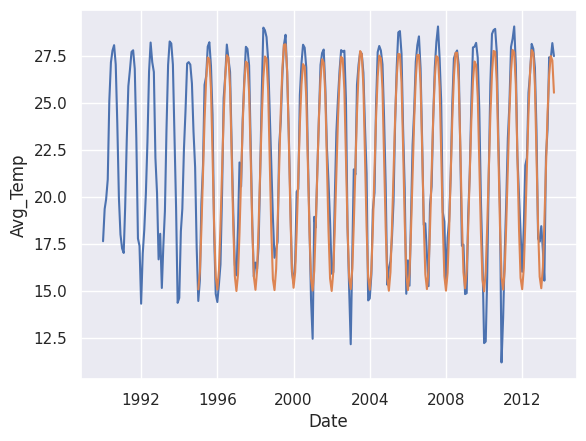

In [15]:
pred_ = pd.DataFrame(test['Date'])
pred_['Avg_Temp'] = pred
pred_["Date"] = pd.to_datetime(pred_["Date"])

pred_
original = florida.loc[florida['Date'] >= '1990-01-01']

sns.lineplot(data=original, x='Date', y='Avg_Temp')
sns.lineplot(data=pred_, x='Date', y='Avg_Temp')
plt.show()
